In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from itertools import combinations
from scipy.stats import ttest_ind
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import *
from sklearn.impute import SimpleImputer,KNNImputer
import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sns.set(style = "whitegrid")

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
np.random.seed(42)

## Read csv


In [3]:
df_train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [4]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [6]:
# Combine train and test datasets

df = pd.concat([df_train, df_test], axis=0)
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
# To check the number of unique values, duplicate values, null values, data types of each column in the dataset

def summary(df):
    print(f"This dataset has {df.shape[0]} rows of data and {df.shape[1]} of variables")
    
    summary = pd.DataFrame(index=df.columns)
    summary["Unique"] = df.nunique()
    summary["Duplicate"] = df.duplicated().sum()
    summary["Null%"] = (df.isna().sum() /  df.shape[0]) * 100
    summary["Null "] = df.isna().sum()
    summary["Types"] = df.dtypes
    
    return summary

summary(df)

This dataset has 12970 rows of data and 14 of variables


,Unique,Duplicate,Null%,Null,Types
PassengerId,12970,0,0.000000,0,object
HomePlanet,3,0,2.220509,288,object
CryoSleep,2,0,2.390131,310,object
Cabin,9825,0,2.305320,299,object
Destination,3,0,2.112567,274,object
Age,80,0,2.081727,270,float64
VIP,2,0,2.282190,296,object
RoomService,1578,0,2.027756,263,float64
FoodCourt,1953,0,2.228219,289,float64
ShoppingMall,1367,0,2.359291,306,float64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


In [9]:
print("Total number of Null Values:")

df.isnull().sum()

Total number of Null Values:


PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

# **Exploratory Data Analysis**

## **Target Analysis**

In [10]:
train = df_train.copy()
test = df_test.copy()

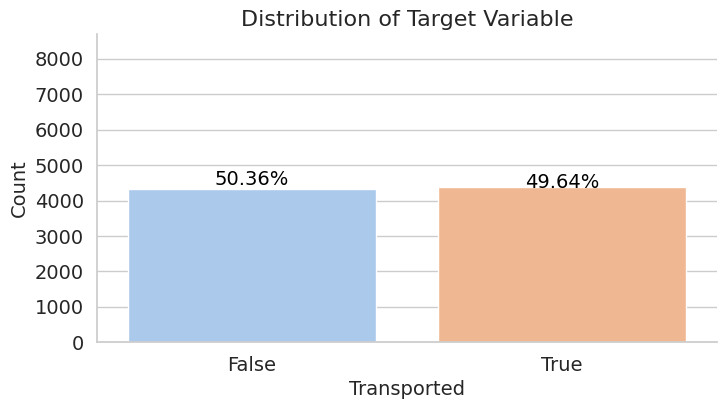

In [11]:
# Calculate the proportion of each class
class_counts = train['Transported'].value_counts()
class_proportions = class_counts / train.shape[0]
class_proportions = class_proportions.values.tolist()
class_proportions_str = [f'{prop:.2%}' for prop in class_proportions]

# Set the color palette
colors = sns.color_palette('pastel')[0:len(class_counts)]

# Plot the distribution of the target variable
plt.figure(figsize=(8, 4))
sns.countplot(x='Transported', data=train, palette=colors)
plt.title('Distribution of Target Variable', fontsize=16)
plt.xlabel('Transported', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.ylim([0, len(train)])
for i, count in enumerate(class_counts):
    plt.text(i, count + 50, class_proportions_str[i], ha='center', fontsize=14, color='black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine()
plt.show()

We have almost same percentage of people who got transported and not being trasnported. Thus, the data is indeed balanced and accuary is a good metric to choose when we build the models.


## **Numerical Features Analysis**

### **Train & Test Data Distributions**

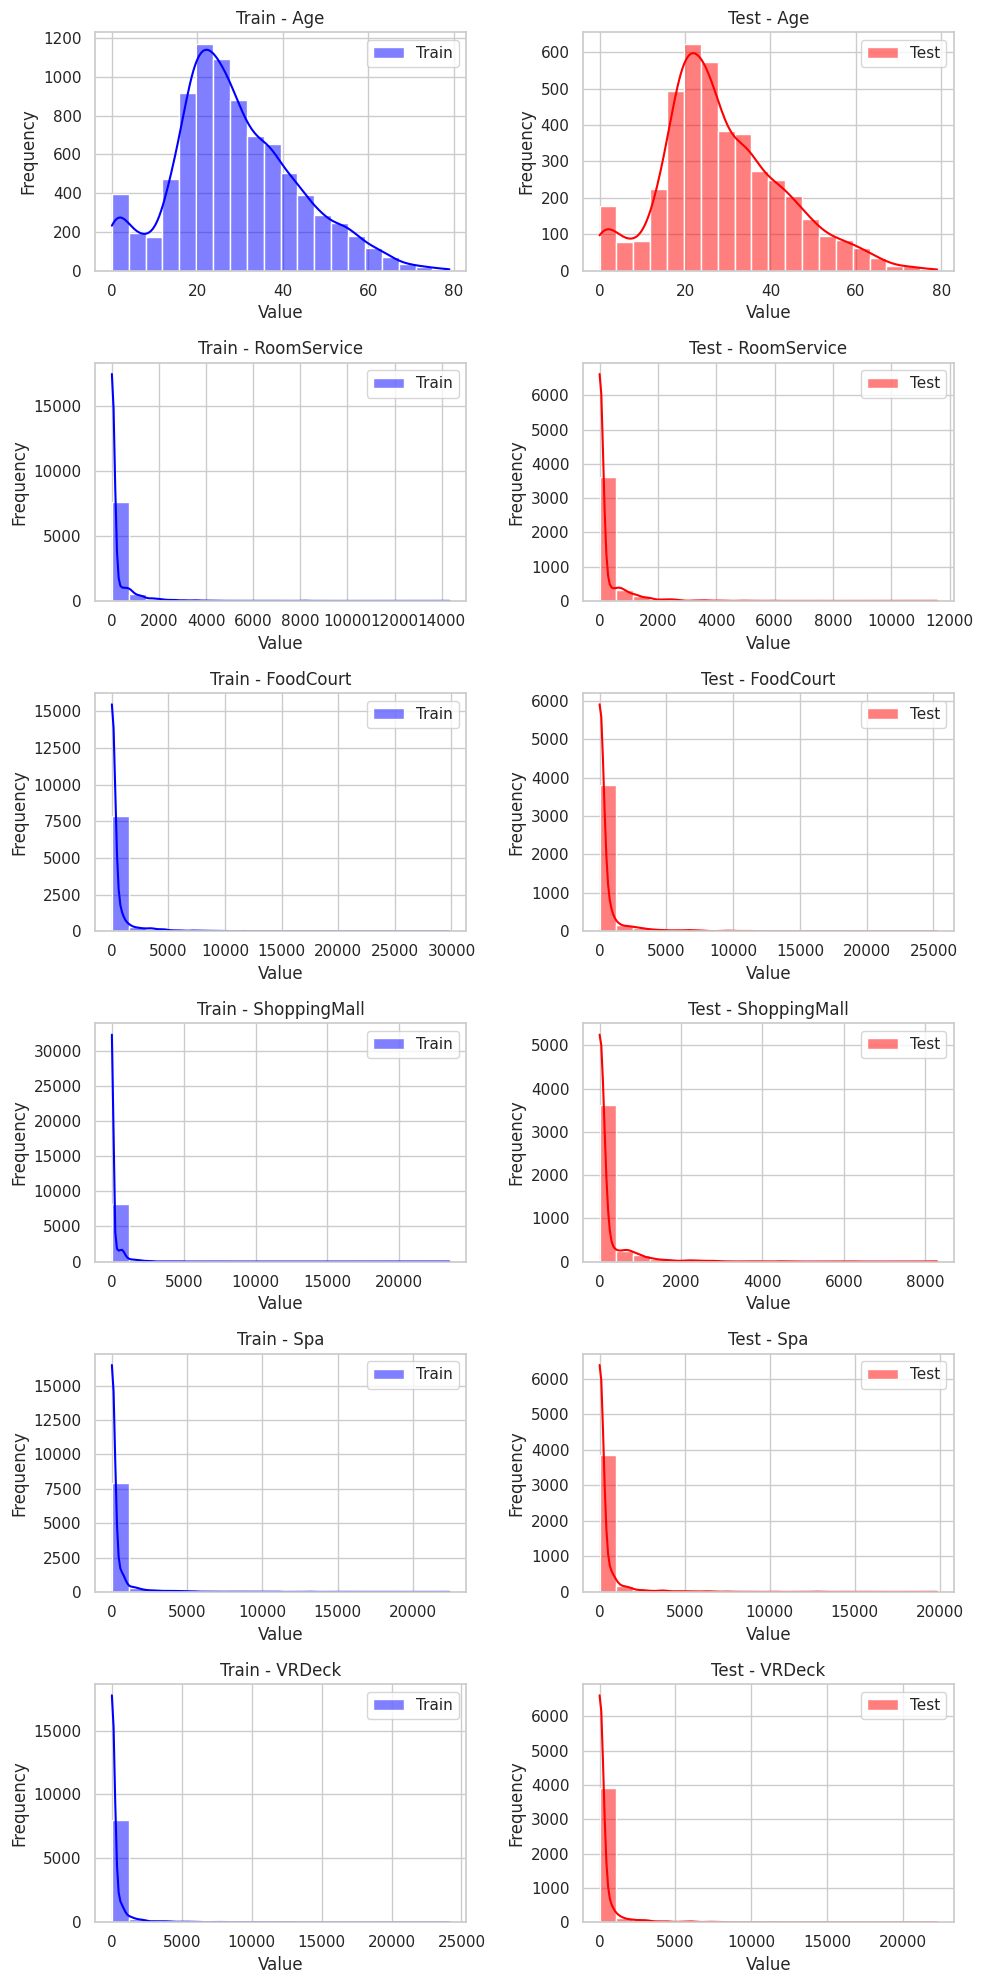

In [12]:
cont_cols=[f for f in train.columns if train[f].dtype in [float,int] and train[f].nunique()>3]

# Create subplots for each continuous column
fig, axs = plt.subplots(len(cont_cols), 2, figsize=(10,20))

# Loop through each continuous column and plot the histograms
for i, col in enumerate(cont_cols):
    # Determine the range of values to plot
    max_val = max(train[col].max(), test[col].max())
    min_val = min(train[col].min(), test[col].min())
    range_val = max_val - min_val

    # Determine the bin size and number of bins
    bin_size = range_val / 20
    num_bins_train = round(range_val / bin_size)
    num_bins_test = round(range_val / bin_size)

    # Plot the histograms
    sns.histplot(train[col], ax=axs[i][0], color='blue', kde=True, label='Train', bins=num_bins_train)
    sns.histplot(test[col], ax=axs[i][1], color='red', kde=True, label='Test', bins=num_bins_test)
    axs[i][0].set_title(f'Train - {col}')
    axs[i][0].set_xlabel('Value')
    axs[i][0].set_ylabel('Frequency')
    axs[i][1].set_title(f'Test - {col}')
    axs[i][1].set_xlabel('Value')
    axs[i][1].set_ylabel('Frequency')
    axs[i][0].legend()
    axs[i][1].legend()

plt.tight_layout()
plt.show()


From the distributions of the continuous features, we can see that they are skewed and have outliers. Thus, we can consider options like log transformations later in the data preprocessing part.

### **Train Data Distributions across Classes**

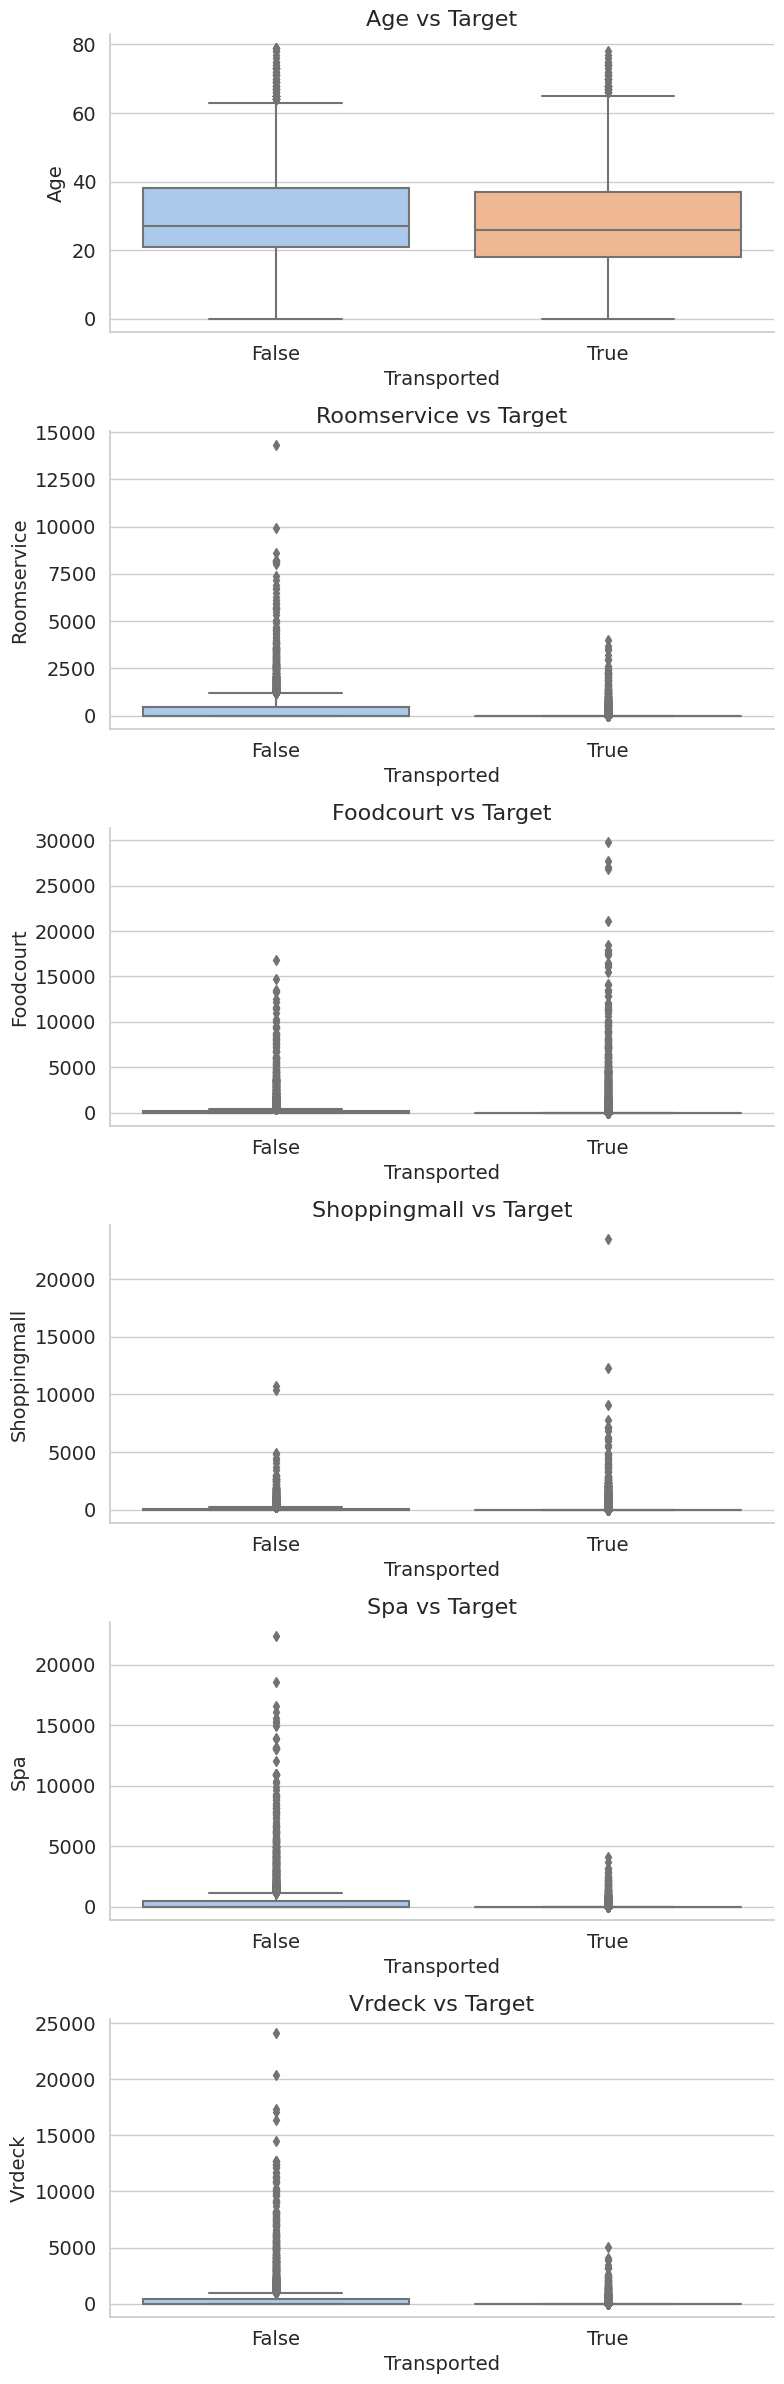

In [13]:
# Create subplots for each continuous feature
fig, axs = plt.subplots(nrows=len(cont_cols), figsize=(8, 4 * len(cont_cols)))
for i, col in enumerate(cont_cols):
    sns.boxplot(x='Transported', y=col, data=train, ax=axs[i], palette='pastel')
    axs[i].set_title(f'{col.title()} vs Target', fontsize=16)
    axs[i].set_xlabel('Transported', fontsize=14)
    axs[i].set_ylabel(col.title(), fontsize=14)
    axs[i].tick_params(axis='both', labelsize=14)
    sns.despine()

# Adjust spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

Distributions between both the classes tell us that using these features directly into model would hinder the performance. These are the things that we could try:

1.   Create Bins
2.   Use algorithms that are unaffected by outliers

## **Bivariate Analysis**

### **Pair Plots**

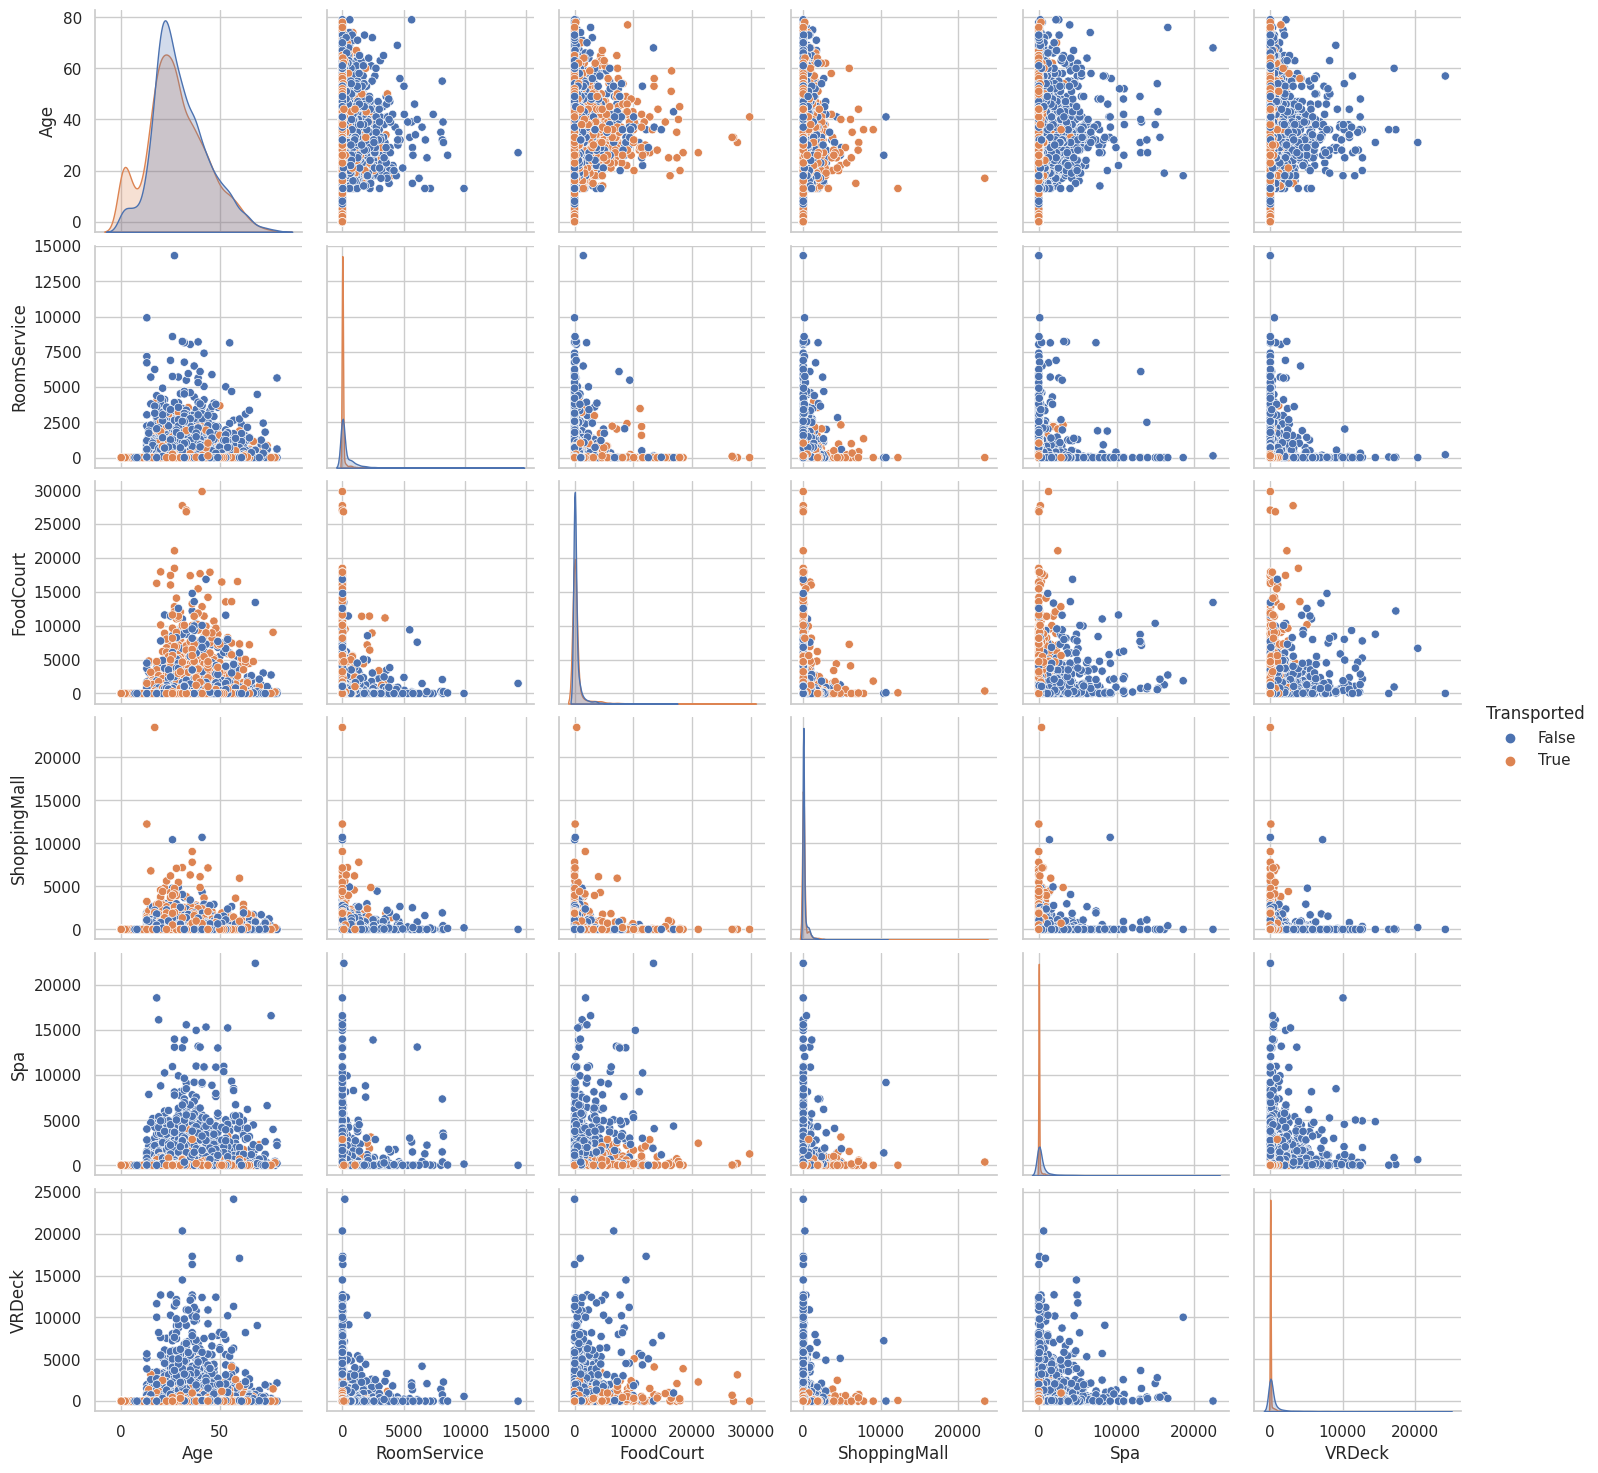

In [14]:
sns.pairplot(data=train, vars=cont_cols, hue='Transported')
plt.show()

The plot of Spa vs VRDeck has a good seperation between the classes. It's very clear that people who had spent less money on these were mostly Transported.
The above statement holds true for Spa vs RoomService.
VRDeck, Spa, RoomService have a good differentiation between classes.
We can create a new feature that tells the total expenditure in the above three features.

### **Violin Plots**

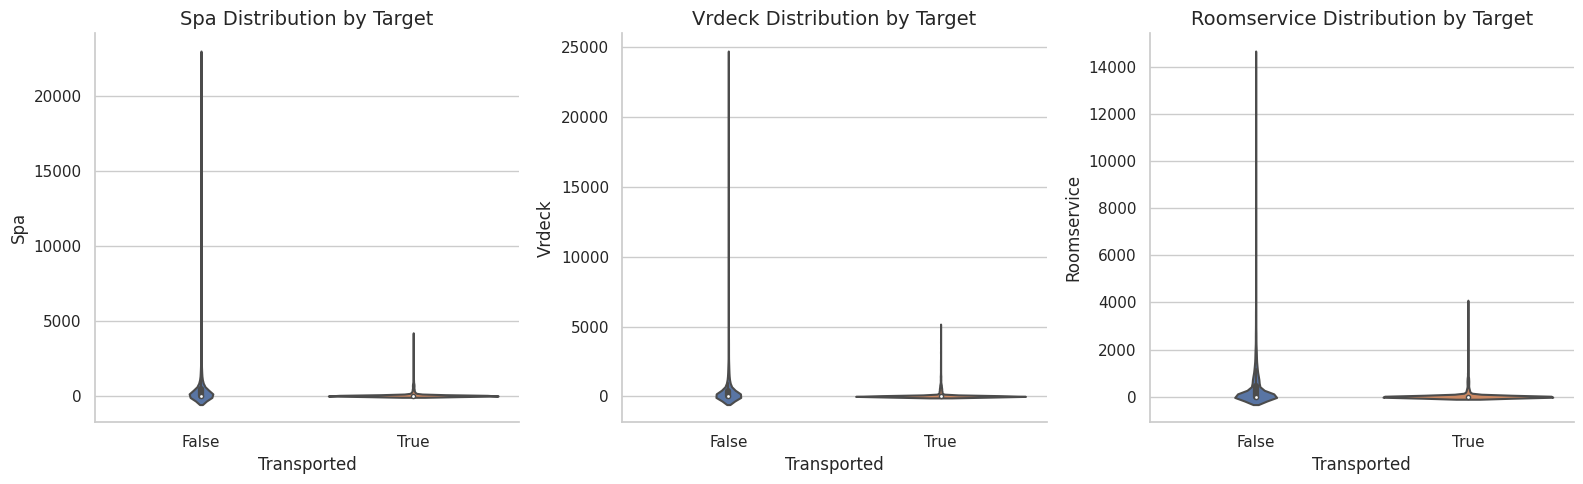

In [15]:
# Define the numerical features to plot
features=["Spa","VRDeck","RoomService"]

# Create a figure with multiple subplots
fig, axs = plt.subplots(1, len(features), figsize=(16, 5))

# Loop through each feature and plot a violin plot on a separate subplot
for i, col in enumerate(features):
    sns.violinplot(x='Transported', y=col, data=train, ax=axs[i])
    axs[i].set_title(f'{col.title()} Distribution by Target', fontsize=14)
    axs[i].set_xlabel('Transported', fontsize=12)
    axs[i].set_ylabel(col.title(), fontsize=12)
    sns.despine()

# Adjust spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

From the Violin plots, we can see that the distribution between classes are very different.

### **t-test**

1.   The t-test is a statistical test used to determine whether the means of two groups are significantly different from each other.

2.   The t-test produces a t-value which is used to calculate a p-value. The p-value represents the probability of observing a t-value as extreme or more extreme than the one observed if the null hypothesis (no difference between means) is true.

3.   If the p-value is less than the chosen significance level (usually 0.05), then we reject the null hypothesis and conclude that there is a significant difference between the means. If the p-value is greater than the significance level, then we fail to reject the null hypothesis and conclude that there is not enough evidence to say that there is a significant difference between the means.

In [16]:
def perform_ttest(train, feature_list, target):

    ttest_results = {}
    table = PrettyTable()

    table.field_names = ['Feature', 't_stat', 'p_val']

    for feature in feature_list:
        group_0 = train[train[target] == 0][feature]
        group_1 = train[train[target] == 1][feature]

        t_stat, p_val = ttest_ind(group_0, group_1, nan_policy='omit')
        table.add_row([feature,t_stat, p_val ])

    return print(table)
perform_ttest(train, cont_cols, 'Transported')

+--------------+--------------------+------------------------+
|   Feature    |       t_stat       |         p_val          |
+--------------+--------------------+------------------------+
|     Age      | 6.941461666045089  | 4.165050977554494e-12  |
| RoomService  | 23.27230572812196  | 3.400493892669515e-116 |
|  FoodCourt   | -4.299893771259008 | 1.727865340729664e-05  |
| ShoppingMall | -0.934056481671101 |   0.3503013444989256   |
|     Spa      | 20.914657362229097 | 9.275825095363414e-95  |
|    VRDeck    | 19.517825470012635 | 4.9897017399892476e-83 |
+--------------+--------------------+------------------------+


All features except ShoppingMall have p-value less than 0.05, that indicates less than the significance levels and there is difference between the classes for variables.

### **ANOVA Test**

In [17]:
from scipy.stats import f_oneway

def perform_anova(train, feature_list, target):
    """
    Performs ANOVA on a list of independent features for a binary classification problem

    :param train: pandas dataframe containing the training data
    :param feature_list: list of feature names to perform ANOVA on
    :param target: name of the target variable (binary)
    :return: dictionary containing ANOVA results
    """
    anova_results = {}
    table = PrettyTable()

    table.field_names = ['Feature', 'F-statistic', 'p-value']

    for feature in feature_list:
        groups = []
        for group_value in train[target].unique():
            group = train[train[target] == group_value][feature].dropna()
            groups.append(group)

        f_stat, p_val = f_oneway(*groups)
        table.add_row([feature, f_stat, p_val])

    return print(table)

perform_anova(train, cont_cols, 'Transported')

+--------------+--------------------+------------------------+
|   Feature    |    F-statistic     |        p-value         |
+--------------+--------------------+------------------------+
|     Age      | 48.18389006117339  | 4.165050977515763e-12  |
| RoomService  | 541.6002139031784  | 3.400493892685092e-116 |
|  FoodCourt   | 18.489086444112008 | 1.727865340726586e-05  |
| ShoppingMall | 0.8724615109517998 |  0.35030134449509687   |
|     Spa      | 437.4228925794437  | 9.275825095347502e-95  |
|    VRDeck    | 380.94551107787373 | 4.9897017400223456e-83 |
+--------------+--------------------+------------------------+


We can see that less number of people from Earth are saved.
Cryosleep has good difference in proportions, people who are in Cryosleep are more likely to be Transported.
All the categories have differences in distributions in the classes.

### **Alternate Method to Pair Plots**

In [18]:
feature_pairs = list(combinations(cont_cols, 2))
table = PrettyTable()
table.field_names = ['Feature Pair', 'Accuracy']

# Fill missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')
train_imputed = imputer.fit_transform(train[cont_cols])

for pair in feature_pairs:
    # Using the entire train data to fit, not a CV because it is time consuming
    x_temp = train_imputed[:, [cont_cols.index(pair[0]), cont_cols.index(pair[1])]]
    y_temp = train['Transported']
    temp_model = CatBoostClassifier(verbose=False)
    temp_model.fit(x_temp, y_temp)
    y_pred_temp = temp_model.predict(x_temp)
    acc = accuracy_score(y_temp, y_pred_temp)
    table.add_row([pair, acc])
    
table.sortby = 'Accuracy'
table.reversesort = True
print(table)

+---------------------------------+--------------------+
|           Feature Pair          |      Accuracy      |
+---------------------------------+--------------------+
|      ('RoomService', 'Spa')     | 0.7508340043713333 |
|    ('RoomService', 'VRDeck')    | 0.7473829518002991 |
|   ('RoomService', 'FoodCourt')  | 0.7428965834579547 |
|  ('FoodCourt', 'ShoppingMall')  | 0.7388703554584148 |
|     ('ShoppingMall', 'Spa')     | 0.7361095134015875 |
|    ('ShoppingMall', 'VRDeck')   | 0.7355343379730818 |
|        ('Spa', 'VRDeck')        | 0.7342689520303692 |
|       ('FoodCourt', 'Spa')      | 0.7341539169446681 |
|     ('FoodCourt', 'VRDeck')     | 0.7238007592315656 |
| ('RoomService', 'ShoppingMall') | 0.7164385137466928 |
|          ('Age', 'Spa')         | 0.6772115495226044 |
|      ('Age', 'RoomService')     | 0.6745657425514782 |
|        ('Age', 'VRDeck')        | 0.6700793742091338 |
|     ('Age', 'ShoppingMall')     | 0.6552398481536869 |
|       ('Age', 'FoodCourt')   

## **Categorical/Discrete Analysis**

In [19]:
cat_features=[f for f in train.columns if f not in cont_cols+["PassengerId","Name","Transported"] and train[f].nunique()<50]
cat_features

['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

### **Target Distributions**

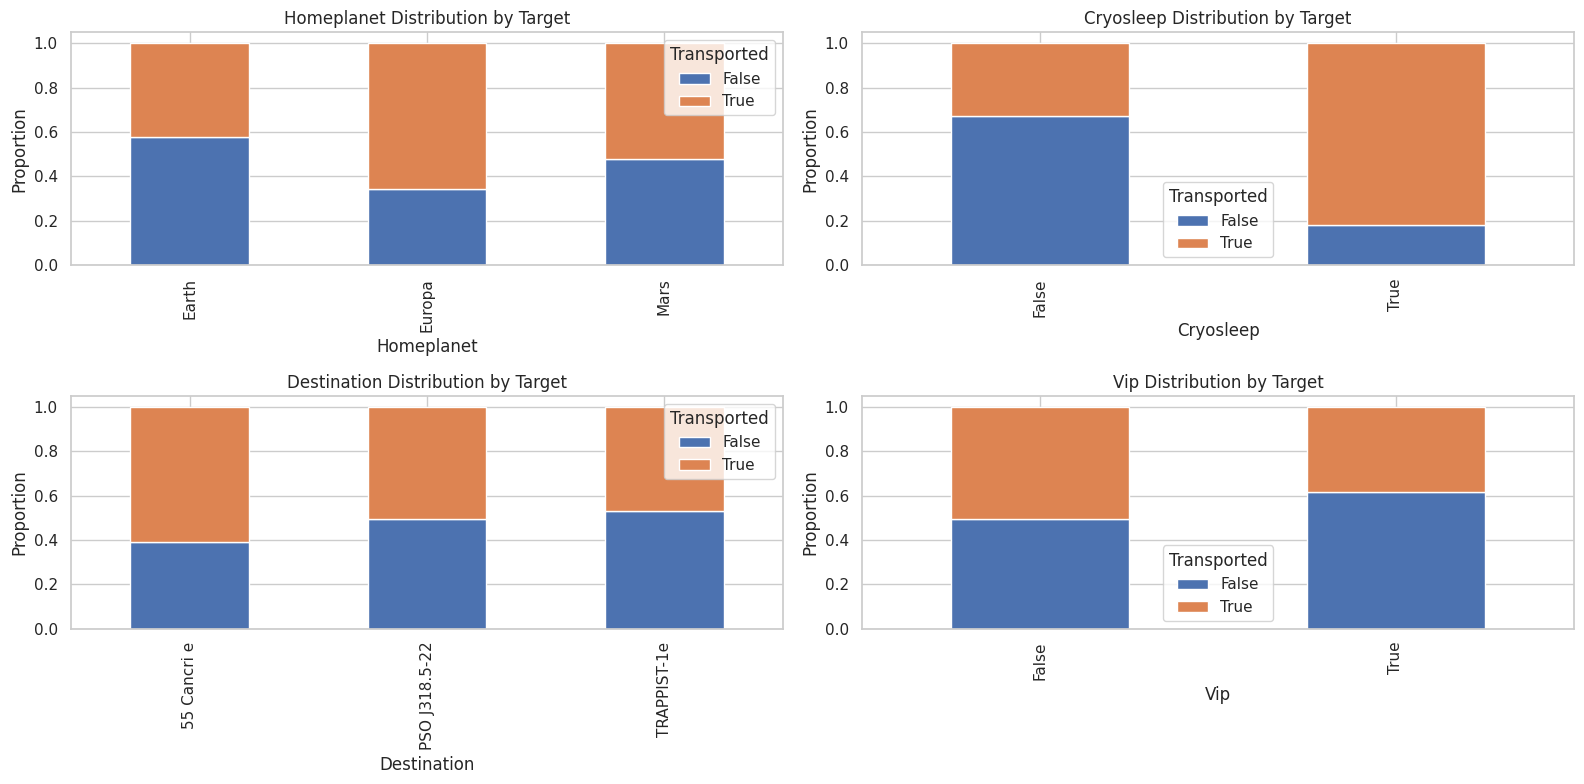

In [20]:
import matplotlib.pyplot as plt

target = 'Transported'

# Create subplots for each categorical feature
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

# Loop through each categorical feature and plot the contingency table in a subplot
for i, col in enumerate(cat_features):
    contingency_table = pd.crosstab(train[col], train[target], normalize='index')
    contingency_table.plot(kind='bar', stacked=True, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f"{col.title()} Distribution by Target")
    axs[i//2, i%2].set_xlabel(col.title())
    axs[i//2, i%2].set_ylabel("Proportion")

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

## Correlation Plot before Data Preprocessing

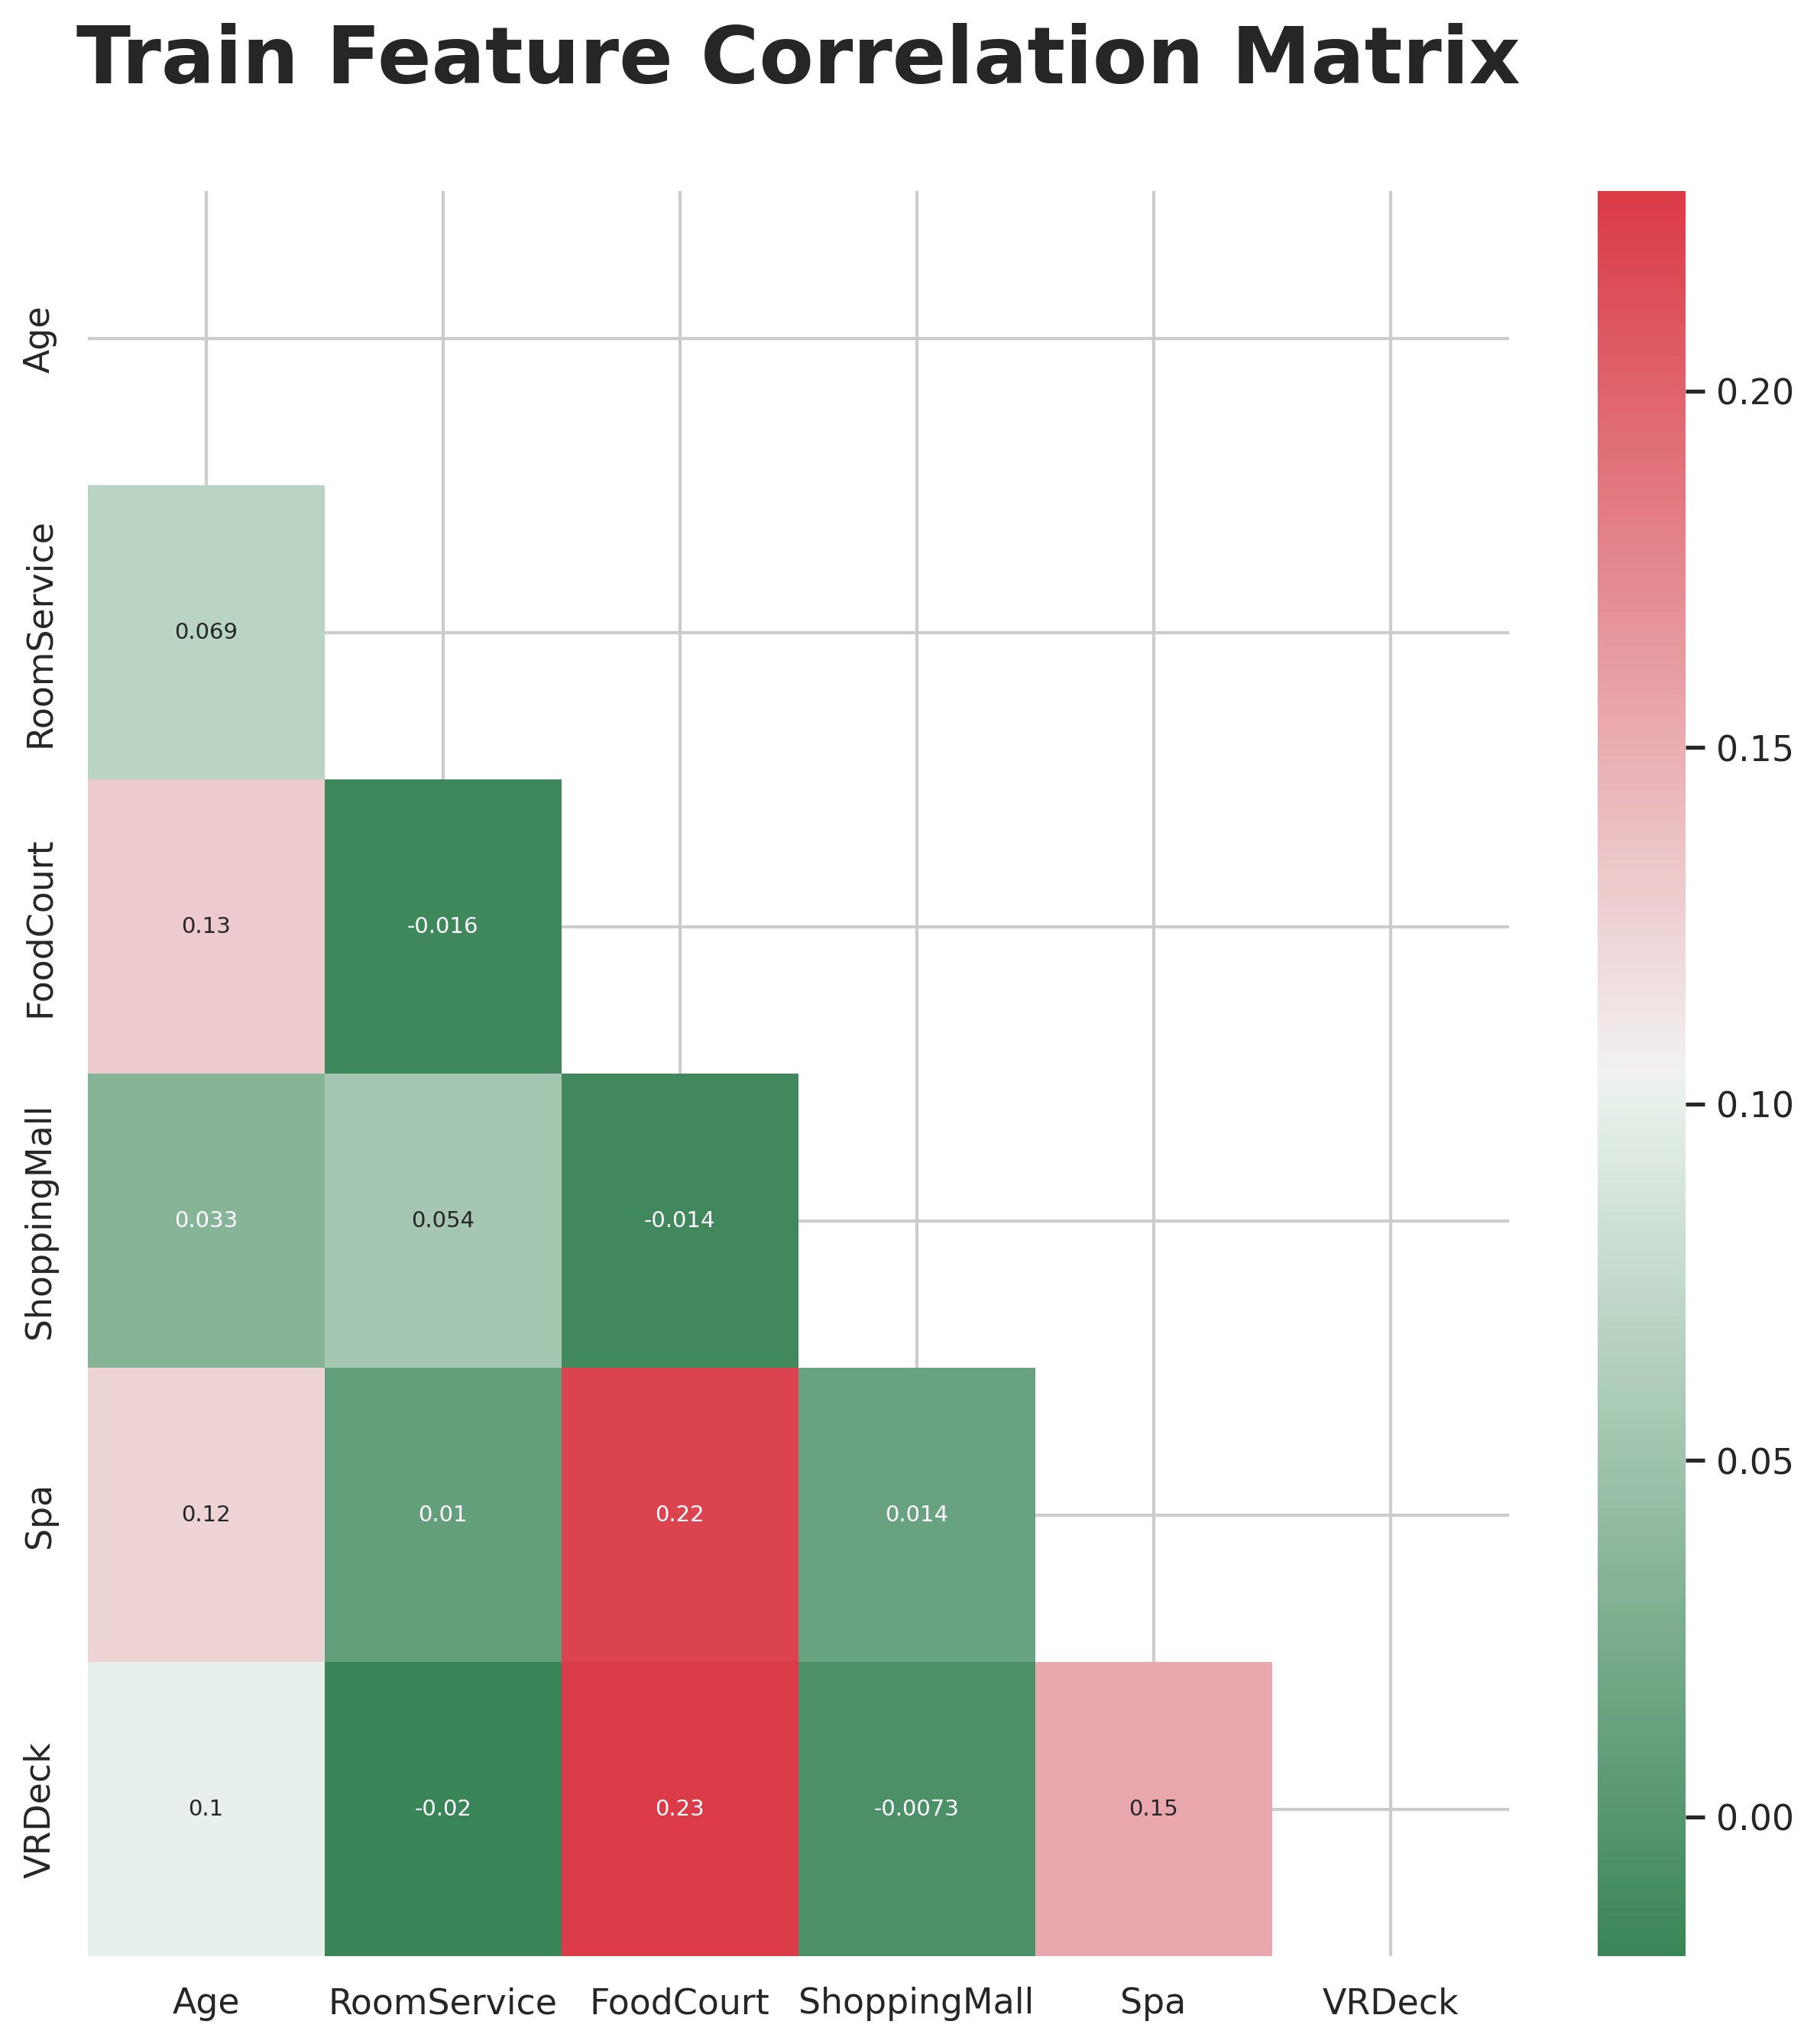

In [21]:
features=[f for f in train.columns if train[f].astype!='O' and f not in ['Transported']]
num_features = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
corr = train[num_features].corr()
plt.figure(figsize = (10, 10), dpi = 300)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, cmap = sns.diverging_palette(500, 10, as_cmap=True), annot = True, annot_kws = {'size' : 7})
plt.title('Train Feature Correlation Matrix\n', fontsize = 25, weight = 'bold')
plt.show()

# **Data Preprocessing**

## Feature Engineering

In [22]:
# Create total spending by computing the sum of all the luxury amenities

df = pd.concat([df_train, df_test], axis=0)

df["TotalSpending"] = df["RoomService"] + df["FoodCourt"] + df["ShoppingMall"] + df["Spa"] + df["VRDeck"]
df["TotalSpending"]

0           0.0
1         736.0
2       10383.0
3        5176.0
4        1091.0
         ...   
4272        0.0
4273     1018.0
4274        0.0
4275     3203.0
4276        0.0
Name: TotalSpending, Length: 12970, dtype: float64

In [23]:
# Split Cabin column into three categories

tmp = df['Cabin'].apply(lambda x: x.split('/') if type(x) != float else ['-1', '-1', '-1']).to_list()
tmp = np.array(tmp)
df['Cabin_deck'] = tmp[:, 0]
df['Cabin_num'] = tmp[:, 1]
df['Cabin_side'] = tmp[:, 2]
df.drop(columns='Cabin', inplace=True)

In [24]:
#################################################################################
# gggg_pp, where gggg is the group number which the passenger is travelling with, 
# while pp is the number of passengers within the group.
# 
# Create new feature called 'Group Size' which will reflect the size of the group 
# that each passenger travelling with.
#################################################################################

group = df['PassengerId'].apply(lambda x: x.split('_')[0]).value_counts().to_dict()
df['Group_size'] = df['PassengerId'].apply(lambda x: group[x.split('_')[0]])
df.set_index('PassengerId', inplace=True)

## Dealing with **Categorical Data**


In [25]:
##########################################################
# Fill null values in Name column with Unknown ('Unk Unk')
# Split each name record into First Name and Last Name
##########################################################

df['Name'].fillna('Unk Unk', inplace=True)
tmp = np.array(df['Name'].apply(lambda x: x if type(x)==float else x.split(' ')).to_list())

df['Name_first'] = tmp[:, 0]
df['Name_last'] = tmp[:, 1]

df.drop(columns=["Name"], inplace=True)

In [26]:
########################################################################################
# HomePlanet & Destination
# Fill in null value for these two columns according to the historical data probability
########################################################################################

for c in ["HomePlanet", "Destination"]:
    
    tmp = df[c].value_counts()

    v = tmp.index
    p = tmp / sum(tmp)

    df.loc[df[c].isna(), c] = np.random.choice(v, df[c].isna().sum(), p=p)

In [27]:
########################################################################################
# Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side,
# where side can be either P for Port or S for Starboard.
#
# Split the Cabin into cabin deck, cabin number, and cabin side.
########################################################################################

# Cabin_deck
df.loc[df['Cabin_deck']=='-1', 'Cabin_deck'] = np.random.choice(['F', 'G'], sum(df['Cabin_deck']=='-1'), p=[0.5, 0.5])

# Cabin_num
df['Cabin_num'] = df['Cabin_num'].astype(int)
df.loc[df['Cabin_num']=='-1', 'Cabin_num'] = int(df['Cabin_num'].mean())

# Cabin side
df.loc[df['Cabin_side']=='-1', 'Cabin_side'] = np.random.choice(['S', 'P'], sum(df['Cabin_side']=='-1'), p=[0.5, 0.5])
df['Cabin_side'] = df['Cabin_side'].map({'S':0, 'P':1})

## Dealing with **Numerical Data**

In [28]:
################################################################################################
# Fill up null values using a uniform distribution within one standard deviation of the mean age
# To maintain the distribution of the 'Age' feeature and precent the model from being biased.
################################################################################################

mean_age = df["Age"].mean()
std_age = df["Age"].std()
is_null = df["Age"].isnull().sum()
rand_sample = np.random.uniform(mean_age - std_age, mean_age + std_age, size = is_null)
df.loc[df['Age'].isna(), 'Age'] = rand_sample

In [29]:
###########################################################################
# Fill up null values in CryoSleep column based on different conditions
###########################################################################

# It can be concluded that if total spending not equals to zero, means the they are not in cryoSleep 
df.loc[(df["CryoSleep"].isnull()) & (df["TotalSpending"] != 0), "CryoSleep"] = False

# The rest of the null values in cryoSleep will be filled with the most frequent data (False)
df.loc[df["CryoSleep"].isnull(), "CryoSleep"] = False

In [30]:
###############################################################
# The dataset tells us that when the passenger is in CryoSleep, 
# then they will not spend on luxury amenities
###############################################################

df.loc[(df["CryoSleep"] == True) & (df["TotalSpending"] != 0), :]['TotalSpending'].nunique()

0

In [31]:
##########################################################
# If CryoSleep is true, then should be no spending at all 
# Fill up luxury amenities and total spending with 0.0
##########################################################

luxury_amenities = ["RoomService", "FoodCourt", "Spa", "VRDeck", "ShoppingMall", "TotalSpending"]

for la in luxury_amenities:
    
    df.loc[(df["CryoSleep"] == True) & (df[la].isnull()), la]  = 0.0

In [32]:
# However, there are people who are not sleeping and not spending money

tmp = df.loc[(df["CryoSleep"] == False) & (df["TotalSpending"].isnull()), :]
tmp.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalSpending,Cabin_deck,Cabin_num,Cabin_side,Group_size,Name_first,Name_last
PassengerId,,,,,,,,,,,,,,,,,,
0014_01,Mars,False,55 Cancri e,27.0,False,1286.0,122.0,NaN,0.0,0.0,False,NaN,F,3,1,1,Flats,Eccle
0031_03,Mars,False,TRAPPIST-1e,20.0,False,NaN,0.0,1750.0,990.0,0.0,True,NaN,F,9,1,3,Dontch,Datie
0050_01,Earth,False,55 Cancri e,35.0,False,790.0,0.0,0.0,NaN,0.0,False,NaN,E,1,0,1,Sony,Lancis
0103_01,Earth,False,TRAPPIST-1e,24.0,False,0.0,NaN,0.0,0.0,17.0,True,NaN,F,24,0,3,Arlen,Mclainez
0115_01,Mars,False,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,NaN,True,NaN,F,24,1,1,Rohs,Pead


In [33]:
################################################################################
# If most of the luxury amenities is 0, then the one left should be 0.0 as well
################################################################################

# RoomService
df.loc[(df["ShoppingMall"] == 0) & (df["Spa"] == 0) & (df["VRDeck"] == 0) & (df["FoodCourt"] == 0) & (df["RoomService"].isnull()), "RoomService" ] = 0.0

# ShoppingMall 
df.loc[(df["RoomService"] == 0) & (df["Spa"] == 0) & (df["VRDeck"] == 0) & (df["FoodCourt"] == 0) & (df["ShoppingMall"].isnull()), "ShoppingMall" ] = 0.0

# Spa
df.loc[(df["RoomService"] == 0) & (df["ShoppingMall"] == 0) & (df["VRDeck"] == 0) & (df["FoodCourt"] == 0) & (df["Spa"].isnull()), "Spa" ] = 0.0

# VRDeck
df.loc[(df["RoomService"] == 0) & (df["Spa"] == 0) & (df["ShoppingMall"] == 0) & (df["FoodCourt"] == 0) & (df["VRDeck"].isnull()), "VRDeck" ] = 0.0

# Food Court
df.loc[(df["RoomService"] == 0) & (df["Spa"] == 0) & (df["ShoppingMall"] == 0) & (df["VRDeck"] == 0) & (df["FoodCourt"].isnull()), "FoodCourt" ] = 0.0

In [34]:
###########################################################################################
# For the rest of the null values, fill up with median to avoid being affected by outliers
###########################################################################################

for i in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
    
    df[i] = df[i].fillna(df[i].median())

In [35]:
# Calculate again total spending after cleaning (to fill up the missing values in the total spending column)

df["TotalSpending"] = df["RoomService"] + df["FoodCourt"] + df["ShoppingMall"] + df["Spa"] + df["VRDeck"]

df["TotalSpending"]

PassengerId
0001_01        0.0
0002_01      736.0
0003_01    10383.0
0003_02     5176.0
0004_01     1091.0
            ...   
9266_02        0.0
9269_01     1018.0
9271_01        0.0
9273_01     3203.0
9277_01        0.0
Name: TotalSpending, Length: 12970, dtype: float64

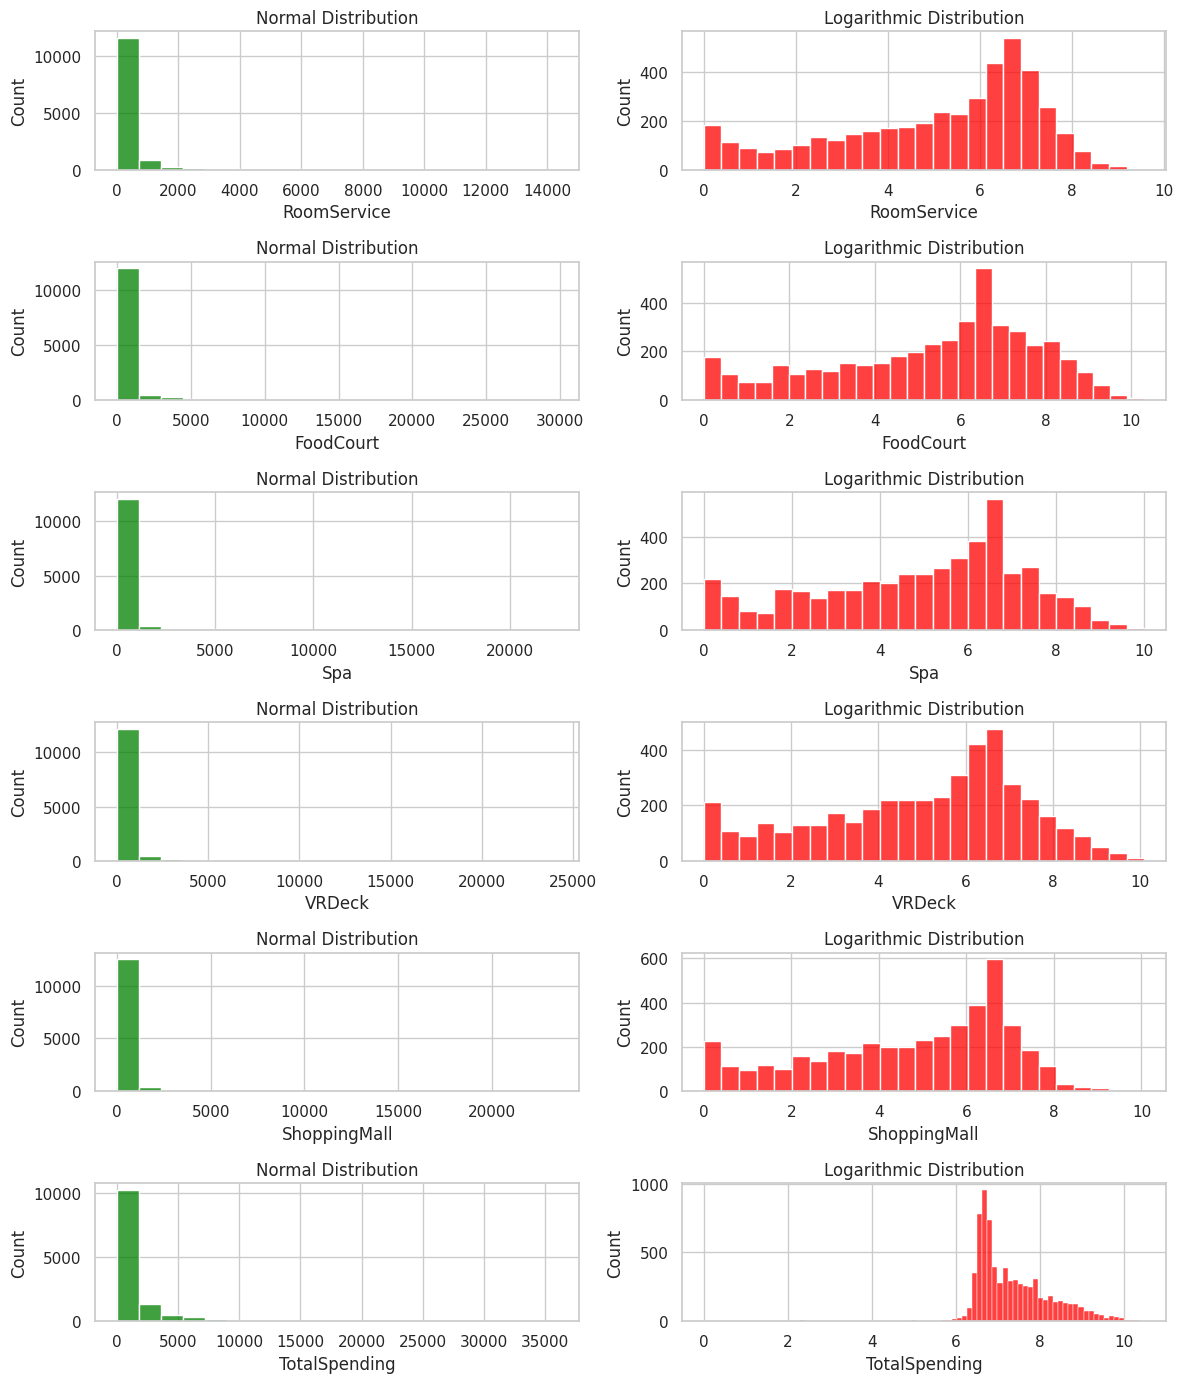

In [36]:
# Visualize the distribution of each luxury amenity as well as Total Spending column

fig, axes = plt.subplots(len(luxury_amenities),2, figsize=(12,14))
for i, col in enumerate(luxury_amenities):
    sns.histplot(data=df, x=col, ax=axes[i, 0], bins=20,color='green')
    sns.histplot(data=np.log(df[[col]]), x=col, ax=axes[i, 1], color='red')
    axes[i, 0].set_title('Normal Distribution')
    axes[i, 1].set_title('Logarithmic Distribution')
plt.tight_layout()

In [37]:
#####################################################
# As these columns contain several extreme values,
# these features will be transformed to a log scale.
# However, since the logarithm of zero is undefined,
# zero values will be replaces with 0.356
# 
# To maintain the core of initial distribution 
# while reducing the impact of outliers
#####################################################

for col in luxury_amenities:
    df.loc[df[col]==0, col] = 0.367
    df[col] = np.log(df[col])

In [38]:
# Fill up null values in VIP with most frequent data (False)

df["VIP"] = df["VIP"].fillna(False)

In [39]:
print("Total number of Null Values:")
df.isnull().sum()

# Not a need to fill up the Transported column as we will be predicting the values of it.

Total number of Null Values:


HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Transported      4277
TotalSpending       0
Cabin_deck          0
Cabin_num           0
Cabin_side          0
Group_size          0
Name_first          0
Name_last           0
dtype: int64

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0001_01 to 9277_01
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     12970 non-null  object 
 1   CryoSleep      12970 non-null  object 
 2   Destination    12970 non-null  object 
 3   Age            12970 non-null  float64
 4   VIP            12970 non-null  bool   
 5   RoomService    12970 non-null  float64
 6   FoodCourt      12970 non-null  float64
 7   ShoppingMall   12970 non-null  float64
 8   Spa            12970 non-null  float64
 9   VRDeck         12970 non-null  float64
 10  Transported    8693 non-null   object 
 11  TotalSpending  12970 non-null  float64
 12  Cabin_deck     12970 non-null  object 
 13  Cabin_num      12970 non-null  int64  
 14  Cabin_side     12970 non-null  int64  
 15  Group_size     12970 non-null  int64  
 16  Name_first     12970 non-null  object 
 17  Name_last      12970 non-null  object 
dtypes: 

In [41]:
# Change datatype

df['CryoSleep'] = df['CryoSleep'].astype("bool")

## **Label Encoding** and **One Hot Encoding**  

In [42]:
############################################################
# Convert the names (string) into integers using Label Encoder
# A unique ineteger will be assigned to each string
############################################################

label_encoder = LabelEncoder()
df["Name_first"] = label_encoder.fit_transform(df.loc[:, "Name_first"])

label_encoder = LabelEncoder()
df["Name_last"] = label_encoder.fit_transform(df.loc[:, "Name_last"])

In [43]:
#######################################################################################
# Convert the categorical data (string) into binary representation using One Hot Encoder
#######################################################################################

categorical_features = ['HomePlanet', 'Destination', 'Cabin_deck']
df = pd.concat([df, pd.get_dummies(df[categorical_features])], axis=1)
df.drop(columns=categorical_features, inplace=True)

In [44]:
# Separate back train test dataset

df_train = df[:df_train.shape[0]]
df_test = df[-df_test.shape[0]:]

df_train.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalSpending,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,False,39.0,False,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,False,-1.002393,...,False,True,False,True,False,False,False,False,False,False
0002_01,False,24.0,False,4.691348,2.197225,3.218876,6.308098,3.784190,True,6.601230,...,False,True,False,False,False,False,False,True,False,False
0003_01,False,58.0,True,3.761200,8.182000,-1.002393,8.812099,3.891820,False,9.247925,...,False,True,True,False,False,False,False,False,False,False
0003_02,False,33.0,False,-1.002393,7.156956,5.916202,8.110427,5.262690,False,8.551788,...,False,True,True,False,False,False,False,False,False,False
0004_01,False,16.0,False,5.713733,4.248495,5.017280,6.336826,0.693147,True,6.994850,...,False,True,False,False,False,False,False,True,False,False


In [45]:
df_test.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalSpending,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0013_01,True,27.0,False,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,NaN,-1.002393,...,False,True,False,False,False,False,False,False,True,False
0018_01,False,19.0,False,-1.002393,2.197225,-1.002393,7.945555,-1.002393,NaN,7.948738,...,False,True,False,False,False,False,False,True,False,False
0019_01,True,31.0,False,-1.002393,-1.002393,-1.002393,-1.002393,-1.002393,NaN,-1.002393,...,False,False,False,False,True,False,False,False,False,False
0021_01,False,38.0,False,-1.002393,8.802673,-1.002393,5.198497,6.371612,NaN,8.911665,...,False,True,False,False,True,False,False,False,False,False
0023_01,False,20.0,False,2.302585,-1.002393,6.453625,-1.002393,-1.002393,NaN,6.469250,...,False,True,False,False,False,False,False,True,False,False


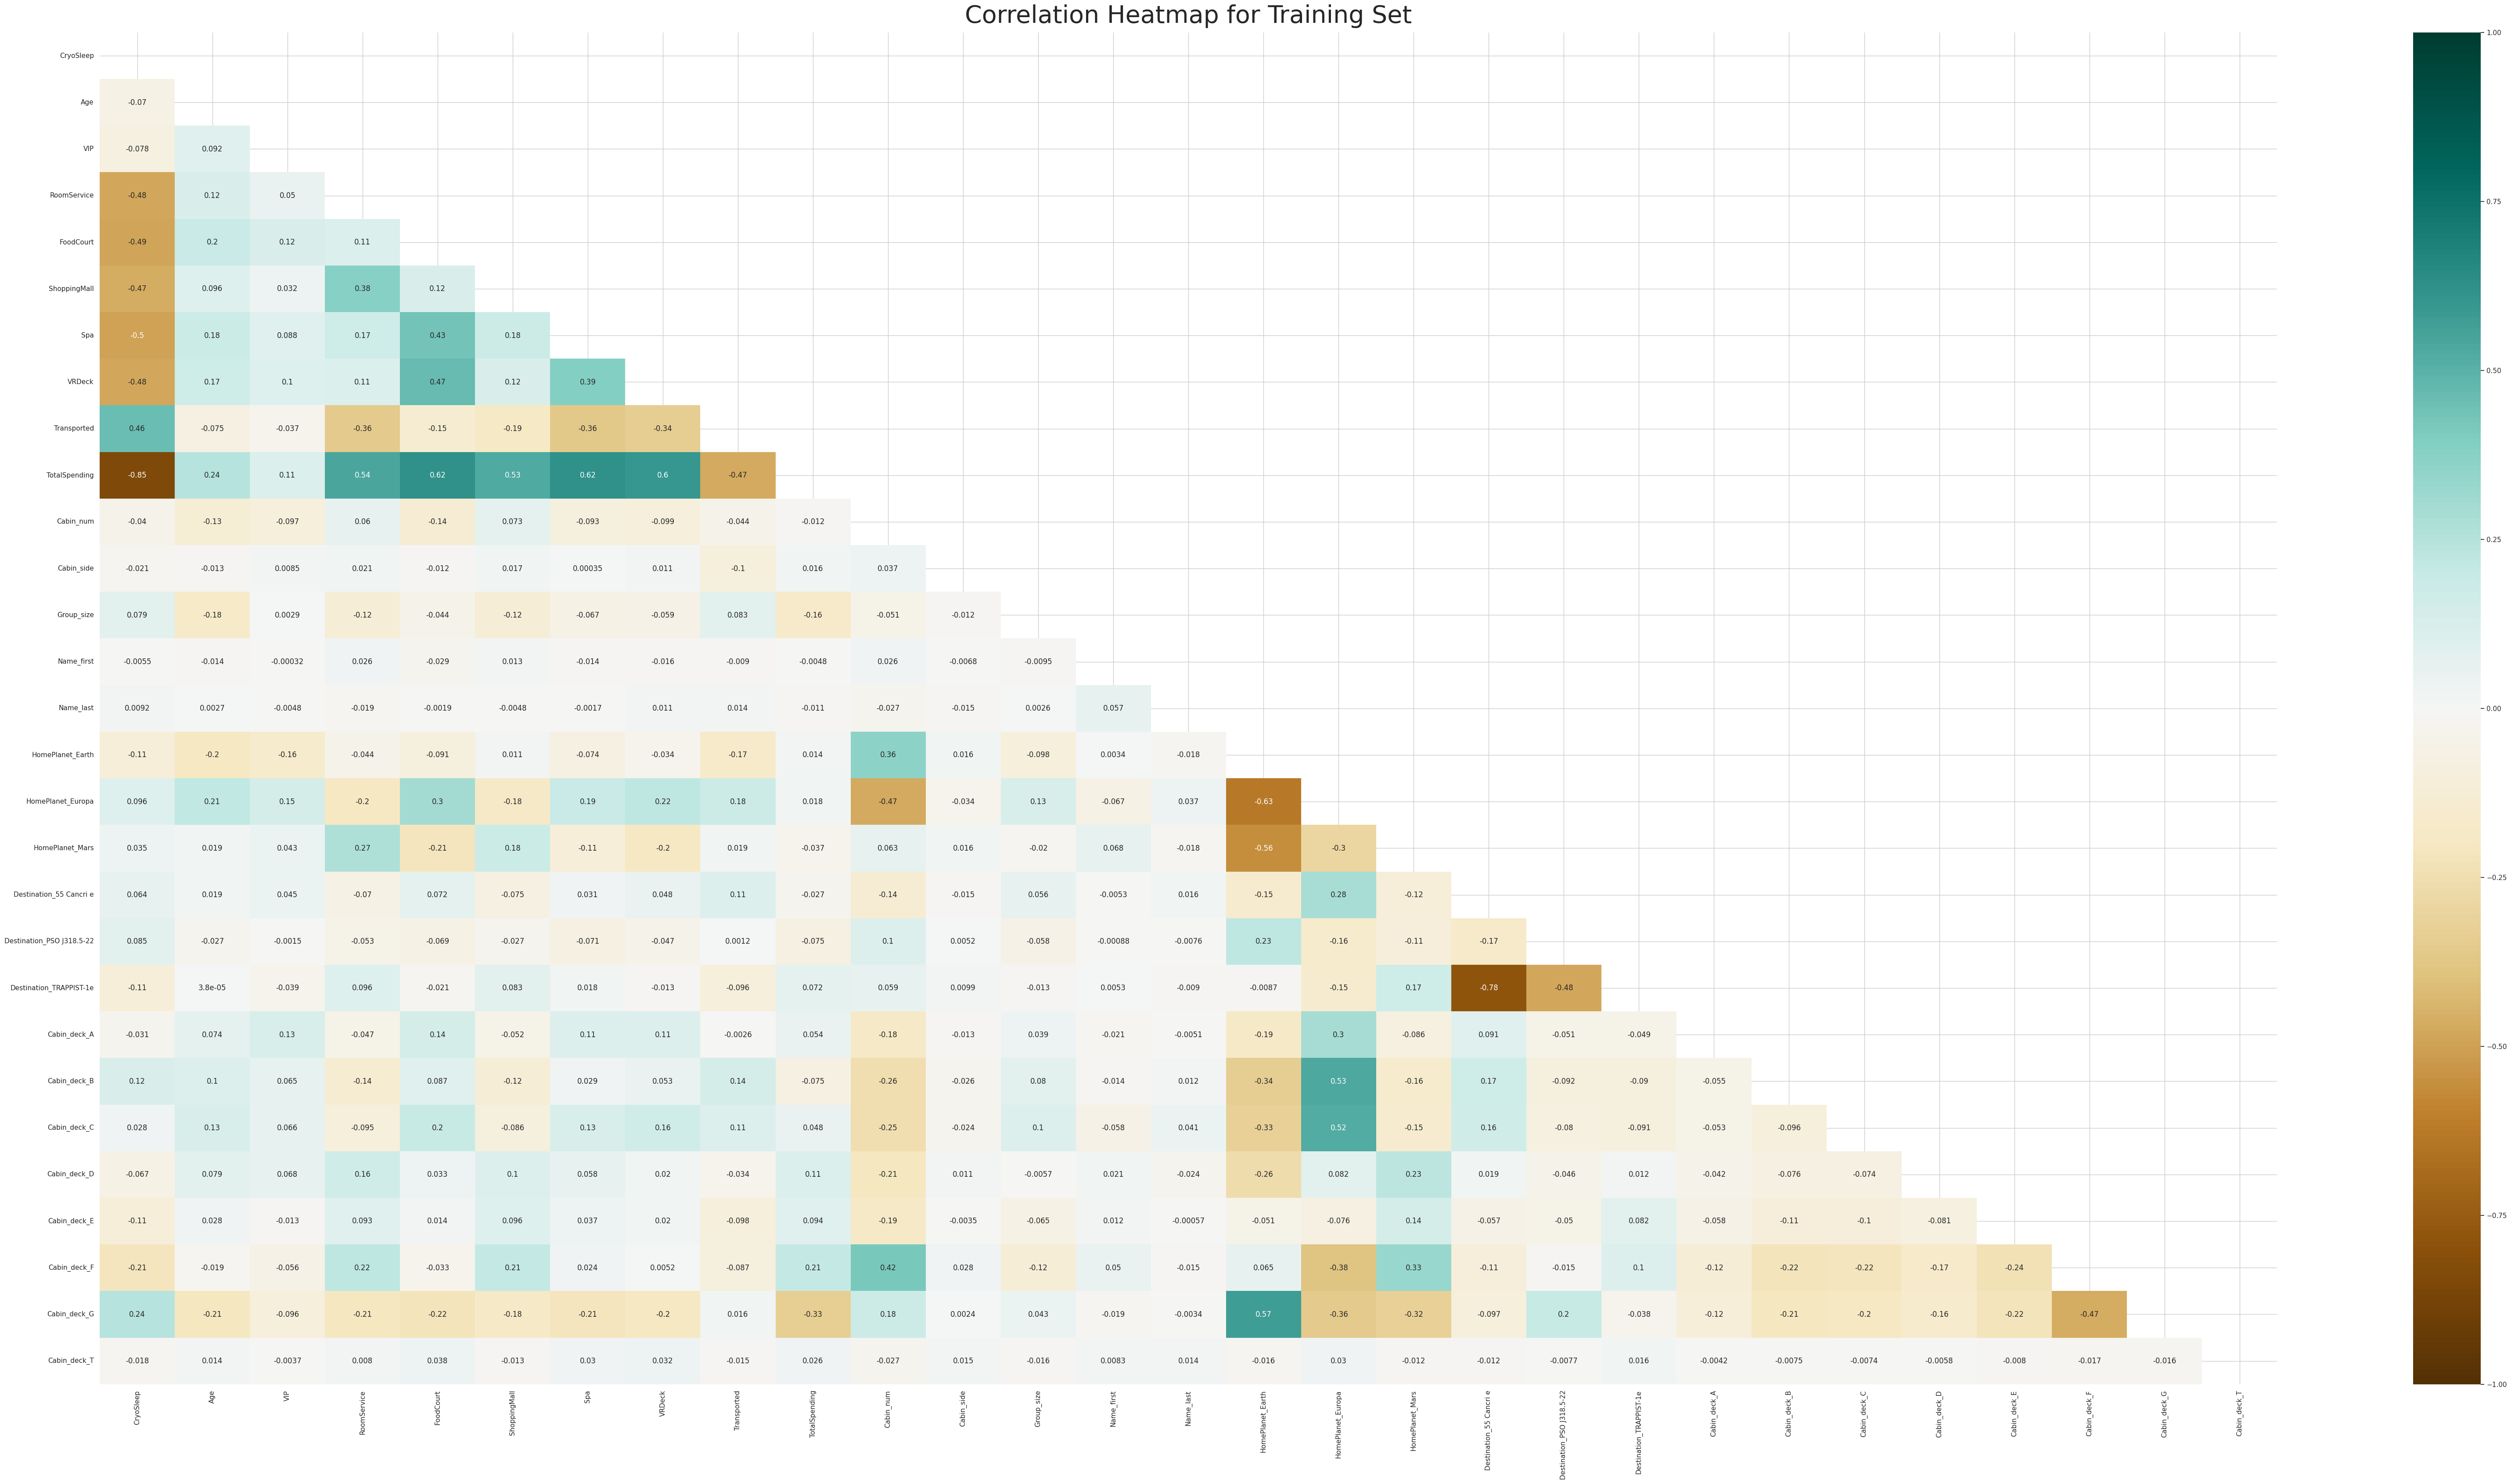

In [46]:
# Print out the correlation heatmap

df_train_corr = df_train.copy()
plt.figure(figsize=(80, 40))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_train_corr.corr(), dtype=bool))
heatmap = sns.heatmap(df_train_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap for Training Set', fontdict={'fontsize':40}, pad=16)

plt.show()

In [47]:
# corr = df_train.corr()
# corr.style.background_gradient(cmap='coolwarm')

In [48]:
# Change the datatype of Transported from object to boolean
df_train['Transported'] = df_train['Transported'].astype("bool")

# Split training set to X_train and y_train
X_train = df_train.drop('Transported', axis=1)
y_train = df_train[['Transported']]

# Drop the Transported column for X_test
X_test = df_test.drop('Transported', axis=1)

# Split the training into Training and Validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Baseline Model

In [49]:
# Baseline

models = [KNeighborsClassifier(),
          DecisionTreeClassifier(), 
          GaussianNB(),
          LogisticRegression(), 
          RandomForestClassifier(),
          LGBMClassifier(verbose=-1),
          XGBClassifier(verbosity=0),
          CatBoostClassifier(verbose=0)
         ]

result_df = pd.DataFrame()
result_df = pd.DataFrame(columns=['Model', 'Accuracy_Score', 'Cross_Validation_Score'])

for each_model in models:
    each_model.fit(X_train, y_train)
    
    accuracy = each_model.score(X_valid, y_valid)
    cv_scores = cross_val_score(each_model, X_train, y_train,cv=5,scoring="accuracy")
    result_df.loc[len(result_df.index)] = [each_model.__class__.__name__, accuracy, np.mean(cv_scores)] 

In [50]:
result_df.sort_values("Cross_Validation_Score")

,Model,Accuracy_Score,Cross_Validation_Score
0,KNeighborsClassifier,0.524540,0.523346
2,GaussianNB,0.747699,0.743945
1,DecisionTreeClassifier,0.756902,0.750576
3,LogisticRegression,0.756902,0.760862
4,RandomForestClassifier,0.797546,0.799838
6,XGBClassifier,0.799847,0.802003
5,LGBMClassifier,0.798313,0.808364
7,CatBoostClassifier,0.803681,0.813777


From the table above, we can see that CatBoostClassifier performs the best among all the classifiers as it has the **highest cross validation score** as well as the **highest accuracy score on validation set**.

# Finding Important Features 

Moving on, we will train a CatBoostClassifier to retrieve the feature importance scores for all our available features.

In [51]:
baseline_model = CatBoostClassifier(verbose=False)
baseline_model.fit(X_train, y_train)

In [52]:
result_df = pd.DataFrame()
result_df = pd.DataFrame(columns=['Num_features', 'Accuracy_Score', 'Cross_Validation_Score'])

for num in range(16, 29):
    importances = []
    feature_importance = pd.DataFrame()
    _df = pd.DataFrame()
    _df["importance"] = baseline_model.feature_importances_
    _df["feature"] = pd.Series(list(X_train.columns))
    _df["fold"] = i
    _df = _df.sort_values('importance', ascending=False)
    _df = _df.head(num)
    feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    important_features = [i for i in _df['feature'].values]
    
    tmp_train = X_train[important_features]
    tmp_valid = X_valid[important_features]
    tmp_test = X_test[important_features]
    
    temp_model = CatBoostClassifier(verbose=False)
    temp_model.fit(tmp_train, y_train)
    y_pred_valid = temp_model.predict(tmp_valid)
    
    cv_scores = cross_val_score(temp_model, tmp_train, y_train,cv=5,scoring="accuracy")
    
    result_df.loc[len(result_df.index)] = [num, accuracy_score(y_valid, y_pred_valid), np.mean(cv_scores)] 

In [53]:
result_df.sort_values("Accuracy_Score")

,Num_features,Accuracy_Score,Cross_Validation_Score
2,18.0,0.799080,0.812154
6,22.0,0.800613,0.813642
5,21.0,0.802147,0.815672
10,26.0,0.802147,0.815265
9,25.0,0.802914,0.812289
7,23.0,0.802914,0.814725
0,16.0,0.805982,0.812154
4,20.0,0.805982,0.811476
1,17.0,0.806748,0.812559
3,19.0,0.807515,0.813100


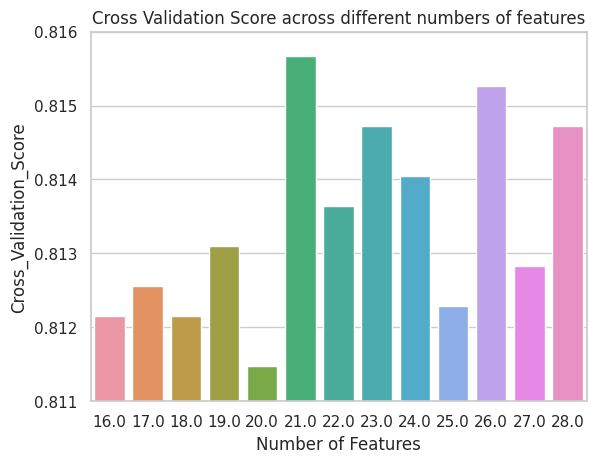

In [54]:
sns.barplot(data=result_df, x="Num_features", y="Cross_Validation_Score")
plt.ylim(0.811, 0.816)
plt.title("Cross Validation Score across different numbers of features")
plt.xlabel("Number of Features")
plt.show()

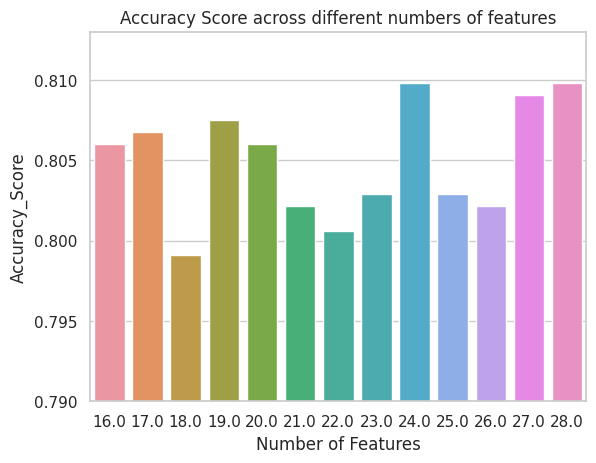

In [55]:
sns.barplot(data=result_df, x="Num_features", y="Accuracy_Score")
plt.ylim(0.790, 0.813)
plt.title("Accuracy Score across different numbers of features")
plt.xlabel("Number of Features")
plt.show()

From the result above, we can see that 28, 24 and 27 features give us higher accuracy score on validation set compared to the others. Thus, we will carry out experiments by extracting these three amounts of features to carry hyperparameter tuning as well as model training using the best hyperparameters.

After trying these three values, extracting **27** features gives us the best result.

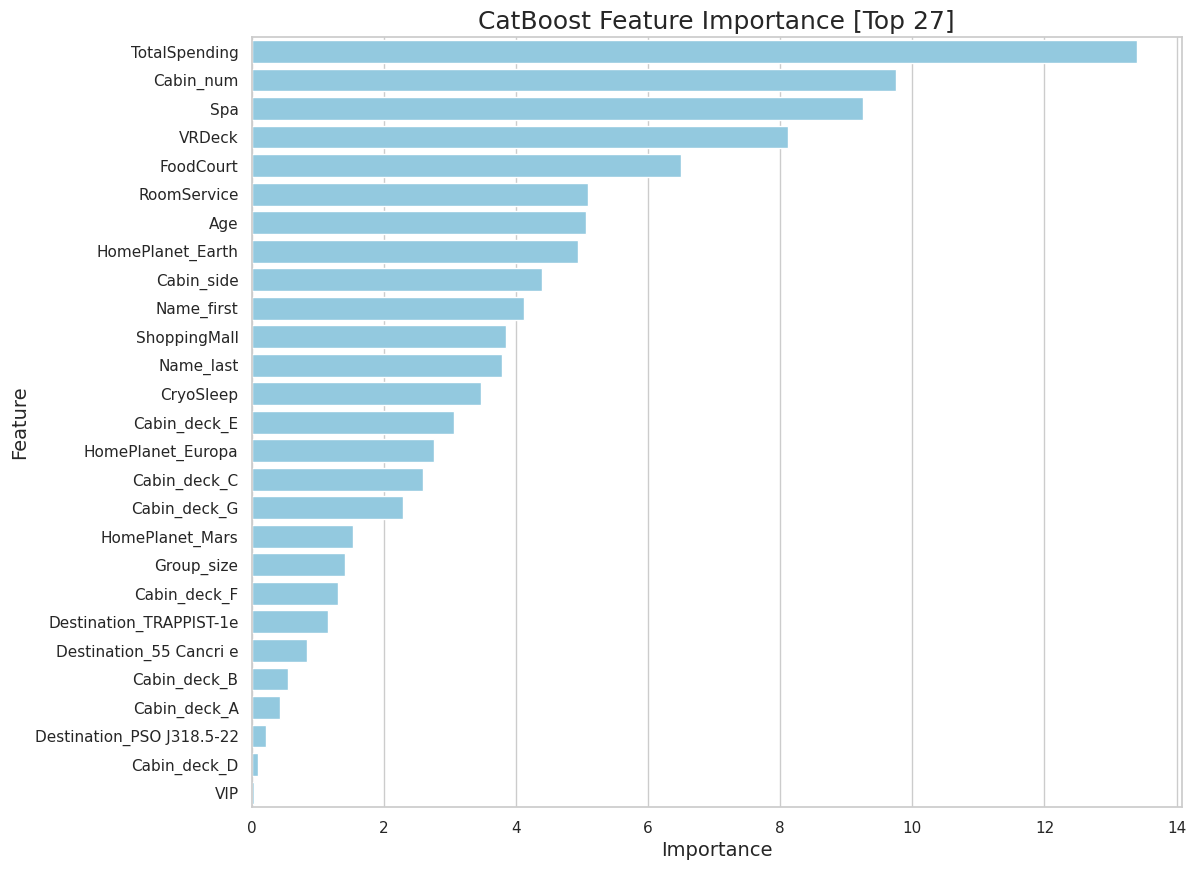

In [56]:
importances = []
feature_importance = pd.DataFrame()
_df = pd.DataFrame()
_df["importance"] = baseline_model.feature_importances_
_df["feature"] = pd.Series(list(X_train.columns))
_df["fold"] = i
_df = _df.sort_values('importance', ascending=False)
_df = _df.head(27)
feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance, color='skyblue', errorbar='sd')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title(f'CatBoost Feature Importance [Top 27]', fontsize=18)
plt.grid(True, axis='x')
plt.show()

In [57]:
final_features = [i for i in _df['feature'].values]
final_features

['TotalSpending',
 'Cabin_num',
 'Spa',
 'VRDeck',
 'FoodCourt',
 'RoomService',
 'Age',
 'HomePlanet_Earth',
 'Cabin_side',
 'Name_first',
 'ShoppingMall',
 'Name_last',
 'CryoSleep',
 'Cabin_deck_E',
 'HomePlanet_Europa',
 'Cabin_deck_C',
 'Cabin_deck_G',
 'HomePlanet_Mars',
 'Group_size',
 'Cabin_deck_F',
 'Destination_TRAPPIST-1e',
 'Destination_55 Cancri e',
 'Cabin_deck_B',
 'Cabin_deck_A',
 'Destination_PSO J318.5-22',
 'Cabin_deck_D',
 'VIP']

# Hyperparameter Tuning

In [58]:
# Training, Validation and Testing with only 27 features

final_train = X_train[final_features]
final_valid = X_valid[final_features]
final_test = X_test[final_features]

In [59]:
# # Comment the Hyperparameter Tuning part to save time

# # define the hyperparameter search space
# param_distributions = {
#     'depth':  np.arange(3, 15,2),
#     'learning_rate': np.arange(0.001, 0.02,0.002),
#     'l2_leaf_reg': [0.1, 0.5, 0.7, 1.0, 1.50, 3.0, 3.50, 5.0, 5.50, 7.0, 7.50],
#     'random_strength': [None, 0.1, 0.2, 0.3],
#     'grow_policy': [None,'SymmetricTree', 'Depthwise', 'Lossguide'],
#     'bootstrap_type': [None, 'Bayesian', 'Bernoulli'],
#     'one_hot_max_size': [None, 10, 50, 70],
#     'border_count':[162, 172, 182],
#     'verbose': [True, False]
# }

# # create a CatBoostClassifier model with default parameters
# model = CatBoostClassifier(iterations=200, eval_metric='Accuracy', loss_function='Logloss', task_type='CPU')

# # perform random search with cross-validation
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_distributions,
#     n_iter=50,  # number of parameter settings that are sampled
#     scoring='neg_log_loss',  # use negative log-loss as the evaluation metric
#     cv=3,  # 5-fold cross-validation
#     verbose=1,
#     random_state=42
# )

# # fit the random search object to the training data
# random_search.fit(final_train, y_train)

# # print the best parameters and best score
# print('Best score:', -1 * random_search.best_score_)
# print('Best parameters:', random_search.best_params_)

# cat_params=random_search.best_params_

In [60]:
# Define the best hyperparameters directly to save time

cat_params = {'learning_rate': 0.018049356549743555,
 'depth': 6,
 'l2_leaf_reg': 7.50,
 'border_count': 182,
 'verbose' : False,
 'random_strength':None,
 'one_hot_max_size': None,
 'max_bin': None}

In [61]:
# Final model with best hyperparameters

final_model = CatBoostClassifier(**cat_params)
final_model.fit(final_train, y_train)
y_pred_valid = final_model.predict(final_valid)

In [62]:
cv_score_train = cross_val_score(final_model, final_train, y_train, cv=5, scoring='accuracy').mean()
print(f"Cross Validation score on Training set: {cv_score_train:.5f}\n")

Cross Validation score on Training set: 0.81445



In [63]:
print(f"Accuracy score on Validation set: {accuracy_score(y_valid, y_pred_valid):.5f}\n")
print(classification_report(y_valid, y_pred_valid))

Accuracy score on Validation set: 0.80752

              precision    recall  f1-score   support

       False       0.82      0.79      0.81       657
        True       0.80      0.82      0.81       647

    accuracy                           0.81      1304
   macro avg       0.81      0.81      0.81      1304
weighted avg       0.81      0.81      0.81      1304



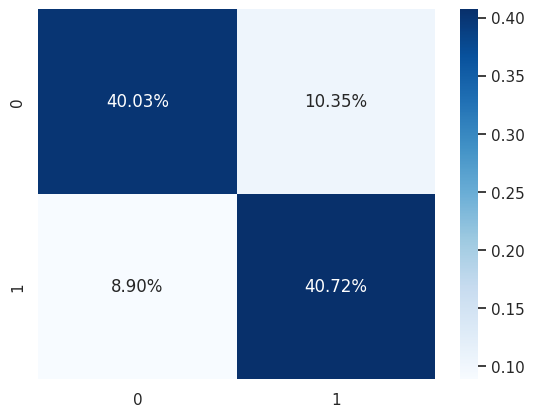

In [64]:
confusion_matrix = metrics.confusion_matrix(y_valid, y_pred_valid)

sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

The difference between the croos validation score on training sets and accuracy score on validation set is quite **small**. This scenario does not strongly indicate model overfitting. Thus, we can move on to prediction.

In [65]:
# Predict testing set

y_pred = final_model.predict(final_test)

In [66]:
# Save the predictions to csv file

FILE_PATH = "/kaggle/input/spaceship-titanic"
sub = pd.read_csv(FILE_PATH+'/sample_submission.csv')
sub['Transported'] = y_pred
sub['Transported'] = sub['Transported'].astype(bool)
sub.to_csv('./final_spaceship_submission.csv', index=False)